In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import pandas as pd
import math

def LSTMtest(data):

    n1 = len(data[0]) - 1 #因为最后一位为label
    n2 = len(data)
    print(n1, n2)

    # 设置常量
    input_size = n1  # 输入神经元个数
    rnn_unit = 10    # LSTM单元(一层神经网络)中的中神经元的个数
    lstm_layers = 7  # LSTM单元个数
    output_size = 1  # 输出神经元个数（预测值）
#     lr = 0.0006      # 学习率
    lr = 0.6

    train_end_index = math.floor(n2*0.9)  # 向下取整
    print('train_end_index', train_end_index)
    # 前90%数据作为训练集，后10%作为测试集
    # 获取训练集
    # time_step 时间步，batch_size 每一批次训练多少个样例
    def get_train_data(batch_size=60, time_step=20, train_begin=0, train_end=train_end_index):
        batch_index = []
        data_train = data[train_begin:train_end]
        normalized_train_data = (data_train - np.mean(data_train, axis=0)) / np.std(data_train, axis=0)  # 标准化
        train_x, train_y = [], []  # 训练集
        for i in range(len(normalized_train_data) - time_step):
            if i % batch_size == 0:
                # 开始位置
                batch_index.append(i)
                # 一次取time_step行数据
            # x存储输入维度（不包括label） :X(最后一个不取）
            # 标准化(归一化）
            x = normalized_train_data[i:i + time_step, :n1]
            # y存储label
            y = normalized_train_data[i:i + time_step, n1, np.newaxis]
            # np.newaxis分别是在行或列上增加维度
            train_x.append(x.tolist())
            train_y.append(y.tolist())
        # 结束位置
        batch_index.append((len(normalized_train_data) - time_step))
        print('batch_index', batch_index)
        # print('train_x', train_x)
        # print('train_y', train_y)
        return batch_index, train_x, train_y

    # 获取测试集
    def get_test_data(time_step=20, test_begin=train_end_index+1):
        data_test = data[test_begin:]
        mean = np.mean(data_test, axis=0)
        std = np.std(data_test, axis=0)  # 矩阵标准差
        # 标准化(归一化）
        normalized_test_data = (data_test - np.mean(data_test, axis=0)) / np.std(data_test, axis=0)
        # " // "表示整数除法。有size个sample
        test_size = (len(normalized_test_data) + time_step - 1) // time_step
        print('test_size$$$$$$$$$$$$$$', test_size)
        test_x, test_y = [], []
        for i in range(test_size - 1):
            x = normalized_test_data[i * time_step:(i + 1) * time_step, :n1]
            y = normalized_test_data[i * time_step:(i + 1) * time_step, n1]
            test_x.append(x.tolist())
            test_y.extend(y)
        test_x.append((normalized_test_data[(i + 1) * time_step:, :n1]).tolist())
        test_y.extend((normalized_test_data[(i + 1) * time_step:, n1]).tolist())
        return mean, std, test_x, test_y

    # ——————————————————定义神经网络变量——————————————————
    # 输入层、输出层权重、偏置、dropout参数
    # 随机产生 w,b
    weights = {
        'in': tf.Variable(tf.random_normal([input_size, rnn_unit])),
        'out': tf.Variable(tf.random_normal([rnn_unit, 1]))
    }
    biases = {
        'in': tf.Variable(tf.constant(0.1, shape=[rnn_unit, ])),
        'out': tf.Variable(tf.constant(0.1, shape=[1, ]))
    }
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')  # dropout 防止过拟合

    # ——————————————————定义神经网络——————————————————
    def lstmCell():
        # basicLstm单元
        # tf.nn.rnn_cell.BasicLSTMCell(self, num_units, forget_bias=1.0,
        # tate_is_tuple=True, activation=None, reuse=None, name=None) 
        # num_units:int类型，LSTM单元(一层神经网络)中的中神经元的个数，和前馈神经网络中隐含层神经元个数意思相同
        # forget_bias:float类型，偏置增加了忘记门。从CudnnLSTM训练的检查点(checkpoin)恢复时，必须手动设置为0.0。
        # state_is_tuple:如果为True，则接受和返回的状态是c_state和m_state的2-tuple；如果为False，则他们沿着列轴连接。后一种即将被弃用。
        # （LSTM会保留两个state，也就是主线的state(c_state),和分线的state(m_state)，会包含在元组（tuple）里边
        # state_is_tuple=True就是判定生成的是否为一个元组）
        #   初始化的 c 和 a 都是zero_state 也就是都为list[]的zero，这是参数state_is_tuple的情况下
        #   初始state,全部为0，慢慢的累加记忆
        # activation:内部状态的激活函数。默认为tanh
        # reuse:布尔类型，描述是否在现有范围中重用变量。如果不为True，并且现有范围已经具有给定变量，则会引发错误。
        # name:String类型，层的名称。具有相同名称的层将共享权重，但为了避免错误，在这种情况下需要reuse=True.
        #

        basicLstm = tf.nn.rnn_cell.BasicLSTMCell(rnn_unit, forget_bias=1.0, state_is_tuple=True)
        # dropout 未使用
        drop = tf.nn.rnn_cell.DropoutWrapper(basicLstm, output_keep_prob=keep_prob)
        return basicLstm

   

    def lstm(X):  # 参数：输入网络批次数目
        batch_size = tf.shape(X)[0]
        time_step = tf.shape(X)[1]
        w_in = weights['in']
        b_in = biases['in']

        # 忘记门（输入门）
        # 因为要进行矩阵乘法,所以reshape
        # 需要将tensor转成2维进行计算
        input = tf.reshape(X, [-1, input_size])
        input_rnn = tf.matmul(input, w_in) + b_in
        # 将tensor转成3维，计算后的结果作为忘记门的输入
        input_rnn = tf.reshape(input_rnn, [-1, time_step, rnn_unit])
        print('input_rnn', input_rnn)
        # 更新门
        # 构建多层的lstm
        cell = tf.nn.rnn_cell.MultiRNNCell([lstmCell() for i in range(lstm_layers)])
        init_state = cell.zero_state(batch_size, dtype=tf.float32)

        # 输出门
        w_out = weights['out']
        b_out = biases['out']
        # output_rnn是最后一层每个step的输出,final_states是每一层的最后那个step的输出
        output_rnn, final_states = tf.nn.dynamic_rnn(cell, input_rnn, initial_state=init_state, dtype=tf.float32)
        output = tf.reshape(output_rnn, [-1, rnn_unit])
        # 输出值，同时作为下一层输入门的输入
        pred = tf.matmul(output, w_out) + b_out
        return pred, final_states

    # ————————————————训练模型————————————————————

    def train_lstm(batch_size=60, time_step=20, train_begin=0, train_end=train_end_index):
        # 于是就有了tf.placeholder，
        # 我们每次可以将 一个minibatch传入到x = tf.placeholder(tf.float32,[None,32])上，
        # 下一次传入的x都替换掉上一次传入的x，
        # 这样就对于所有传入的minibatch x就只会产生一个op，
        # 不会产生其他多余的op，进而减少了graph的开销。

        X = tf.placeholder(tf.float32, shape=[None, time_step, input_size])
        Y = tf.placeholder(tf.float32, shape=[None, time_step, output_size])
        batch_index, train_x, train_y = get_train_data(batch_size, time_step, train_begin, train_end)
        # 用tf.variable_scope来定义重复利用,LSTM会经常用到
        with tf.variable_scope("sec_lstm"):
            pred, state_ = lstm(X) # pred输出值，state_是每一层的最后那个step的输出
        print('pred,state_', pred, state_)

        # 损失函数
        # [-1]——列表从后往前数第一列，即pred为预测值，Y为真实值(Label)
        #tf.reduce_mean 函数用于计算张量tensor沿着指定的数轴（tensor的某一维度）上的的平均值
        loss = tf.reduce_mean(tf.square(tf.reshape(pred, [-1]) - tf.reshape(Y, [-1])))
        # 误差loss反向传播——均方误差损失
        # 本质上是带有动量项的RMSprop，它利用梯度的一阶矩估计和二阶矩估计动态调整每个参数的学习率。
        # Adam的优点主要在于经过偏置校正后，每一次迭代学习率都有个确定范围，使得参数比较平稳.
        train_op = tf.train.AdamOptimizer(lr).minimize(loss)
        saver = tf.train.Saver(tf.global_variables(), max_to_keep=15)

        with tf.Session() as sess:
            # 初始化
            sess.run(tf.global_variables_initializer())
            theloss = []
            # 迭代次数
            for i in range(200):
                for step in range(len(batch_index) - 1):
                    # sess.run(b, feed_dict = replace_dict)
                    state_, loss_ = sess.run([train_op, loss],
                                        feed_dict={X: train_x[batch_index[step]:batch_index[step + 1]],
                                                   Y: train_y[batch_index[step]:batch_index[step + 1]],
                                                   keep_prob: 0.5})
                                        #  使用feed_dict完成矩阵乘法 处理多输入
                                        #  feed_dict的作用是给使用placeholder创建出来的tensor赋值


                                        #  [batch_index[step]: batch_index[step + 1]]这个区间的X与Y
                                        #  keep_prob的意思是：留下的神经元的概率，如果keep_prob为0的话， 就是让所有的神经元都失活。
                print("Number of iterations:", i, " loss:", loss_)
                theloss.append(loss_)
            print("model_save: ", saver.save(sess, '/Users/rumeng/Downloads/qingzang/trainSet2/model_save2/modle.ckpt'))
            print("The train has finished")
        return theloss

    theloss = train_lstm()

    # ————————————————预测模型————————————————————
    def prediction(time_step=20):

        X = tf.placeholder(tf.float32, shape=[None, time_step, input_size])
        mean, std, test_x, test_y = get_test_data(time_step)
        # 用tf.variable_scope来定义重复利用,LSTM会经常用到
        with tf.variable_scope("sec_lstm", reuse=tf.AUTO_REUSE):
            pred, state_ = lstm(X)
        saver = tf.train.Saver(tf.global_variables())
        with tf.Session() as sess:
            # 参数恢复（读取已存在模型）
            module_file = tf.train.latest_checkpoint('/Users/rumeng/Downloads/qingzang/trainSet2/model_save2')
            saver.restore(sess, module_file)
            test_predict = []
            for step in range(len(test_x) - 1):
                predict = sess.run(pred, feed_dict={X: [test_x[step]], keep_prob: 1})
                predict = predict.reshape((-1))
                test_predict.extend(predict)  # 把predict的内容添加到列表

            # 相对误差=（测量值-计算值）/计算值×100%
            test_y = np.array(test_y) * std[n1] + mean[n1]
            test_predict = np.array(test_predict) * std[n1] + mean[n1]
            acc = np.average(np.abs(test_predict - test_y[:len(test_predict)]) / test_y[:len(test_predict)])
            print("预测的相对误差:", acc)

            print(theloss)
            plt.figure()
            plt.plot(list(range(len(theloss))), theloss, color='b', )
            plt.xlabel('times', fontsize=14)
            plt.ylabel('loss valuet', fontsize=14)
            plt.title('loss-----blue', fontsize=10)
            plt.show()
            # 以折线图表示预测结果
            plt.figure()
            plt.plot(list(range(len(test_predict))), test_predict, color='b', )
            plt.plot(list(range(len(test_y))), test_y, color='r')
            plt.xlabel('time value/day', fontsize=14)
            plt.ylabel('close value/point', fontsize=14)
            plt.title('predict-----blue,real-----red', fontsize=10)
            plt.show()



    prediction()



Instructions for updating:
non-resource variables are not supported in the long term


getdata


Exception in Tkinter callback
Traceback (most recent call last):
  File "/Users/rumeng/opt/anaconda3/lib/python3.9/tkinter/__init__.py", line 1892, in __call__
    return self.func(*args)
  File "/var/folders/97/t5p37xd91tbg2h4b_0h0x6t00000gn/T/ipykernel_5540/2176248138.py", line 30, in <lambda>
    tk.Button(win, text='选择数据集', width=20, height=2, bg='#FF8C00', command=lambda: getdata(var, canvas),
  File "/var/folders/97/t5p37xd91tbg2h4b_0h0x6t00000gn/T/ipykernel_5540/2176248138.py", line 56, in getdata
    lines = f.readlines()  # 读取所有行
UnicodeDecodeError: 'gb2312' codec can't decode byte 0xbf in position 2: illegal multibyte sequence
2022-07-22 05:55:07.687 python[5540:219338] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit


2 3 4 6 7 8 9 10 5
gettraindata
['2', '3', '4', '6', '7', '8', '9', '10', '5']
[[ 1.75000000e+01  1.85500000e+01  1.72000000e+01 ...  2.83832833e+07
   4.81380000e-02  1.82900000e+01]
 [ 1.83500000e+01  1.88500000e+01  1.80000000e+01 ...  2.80263585e+07
  -1.25750000e-02  1.80600000e+01]
 [ 1.80200000e+01  1.90500000e+01  1.77500000e+01 ...  2.91436884e+07
   3.98670000e-02  1.87800000e+01]
 ...
 [ 9.35000000e+00  9.42000000e+00  9.27000000e+00 ...  1.59684826e+08
  -4.28300000e-03  9.30000000e+00]
 [ 9.45000000e+00  9.49000000e+00  9.28000000e+00 ...  1.59341417e+08
  -2.15100000e-03  9.28000000e+00]
 [ 9.31000000e+00  9.46000000e+00  9.31000000e+00 ...  1.61058459e+08
   1.07760000e-02  9.38000000e+00]]
pred begin
8 4441
train_end_index 3996
batch_index [0, 60, 120, 180, 240, 300, 360, 420, 480, 540, 600, 660, 720, 780, 840, 900, 960, 1020, 1080, 1140, 1200, 1260, 1320, 1380, 1440, 1500, 1560, 1620, 1680, 1740, 1800, 1860, 1920, 1980, 2040, 2100, 2160, 2220, 2280, 2340, 2400, 2460, 2

/var/folders/97/t5p37xd91tbg2h4b_0h0x6t00000gn/T/ipykernel_5540/3069974248.py:102: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  basicLstm = tf.nn.rnn_cell.BasicLSTMCell(rnn_unit, forget_bias=1.0, state_is_tuple=True)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
pred,state_ Tensor("sec_lstm/add_1:0", shape=(?, 1), dtype=float32) (LSTMStateTuple(c=<tf.Tensor 'sec_lstm/rnn/while/Exit_3:0' shape=(?, 10) dtype=float32>, h=<tf.Tensor 'sec_lstm/rnn/while/Exit_4:0' shape=(?, 10) dtype=float32>), LSTMStateTuple(c=<tf.Tensor 'sec_lstm/rnn/while/Exit_5:0' shape=(?, 10) dtype=float32>, h=<tf.Tensor 'sec_lstm/rnn/while/Exit_6:0' shape=(?, 10) dtype=float32>), LSTMStateTuple(c=<tf.Tensor 'sec_lstm/rnn/while/Exit_7:0' shape=(?, 10) dtype=float32>, h=<tf.Tensor 'sec_lstm/rnn/while/Exit_8:0' shape=(?, 10) dtype=float32>), LSTMStateTuple(c=<tf.Tensor 'sec_lstm/rnn/while/Exit_9:0' shape=(?, 10) dtype=float32>, h=<tf.Tensor 'sec_lstm/rnn/while/Exit_10:0' shape=(?, 10) dtype=float32>), LSTMStateTuple(c=<tf.Tensor 'sec_lstm/rnn/while/Exit_11:0' shape=(?, 10) dtype=float32>, h=<tf.Tensor 'sec_lstm/rnn/while/Exit_12:0' shape=(?, 10) dtype=float32>), 

2022-07-22 05:55:24.986940: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-22 05:55:25.019197: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Number of iterations: 0  loss: 0.52335566
Number of iterations: 1  loss: 0.01896425
Number of iterations: 2  loss: 0.07801451
Number of iterations: 3  loss: 0.084922954
Number of iterations: 4  loss: 0.0863801
Number of iterations: 5  loss: 0.087104216
Number of iterations: 6  loss: 0.08774601
Number of iterations: 7  loss: 0.088318944
Number of iterations: 8  loss: 0.08858788
Number of iterations: 9  loss: 0.08879392
Number of iterations: 10  loss: 0.088952854
Number of iterations: 11  loss: 0.0890738
Number of iterations: 12  loss: 0.0889534
Number of iterations: 13  loss: 0.15997572
Number of iterations: 14  loss: 0.1591565
Number of iterations: 15  loss: 0.16569528
Number of iterations: 16  loss: 0.17069164
Number of iterations: 17  loss: 0.17516628
Number of iterations: 18  loss: 0.17919396
Number of iterations: 19  loss: 0.18283133
Number of iterations: 20  loss: 0.1861268
Number of iterations: 21  loss: 0.1891211
Number of iterations: 22  loss: 0.19184966
Number of iterations: 2

Number of iterations: 190  loss: 0.22662792
Number of iterations: 191  loss: 0.22662798
Number of iterations: 192  loss: 0.22662787
Number of iterations: 193  loss: 0.22662807
Number of iterations: 194  loss: 0.22662807
Number of iterations: 195  loss: 0.2266283
Number of iterations: 196  loss: 0.22662826
Number of iterations: 197  loss: 0.2266283
Number of iterations: 198  loss: 0.2266283
Number of iterations: 199  loss: 0.2266283
INFO:tensorflow:/Users/rumeng/Downloads/qingzang/trainSet2/model_save2/modle.ckpt.meta
INFO:tensorflow:900
INFO:tensorflow:/Users/rumeng/Downloads/qingzang/trainSet2/model_save2/modle.ckpt.index
INFO:tensorflow:900
INFO:tensorflow:/Users/rumeng/Downloads/qingzang/trainSet2/model_save2/modle.ckpt.data-00000-of-00001
INFO:tensorflow:1000
model_save:  /Users/rumeng/Downloads/qingzang/trainSet2/model_save2/modle.ckpt
The train has finished
test_size$$$$$$$$$$$$$$ 23
input_rnn Tensor("sec_lstm_1/Reshape_1:0", shape=(?, 20, 10), dtype=float32)
INFO:tensorflow:Rest

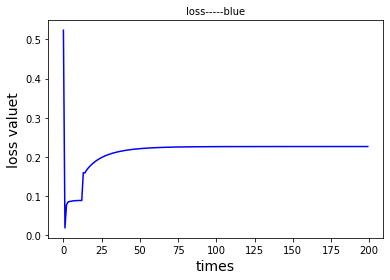

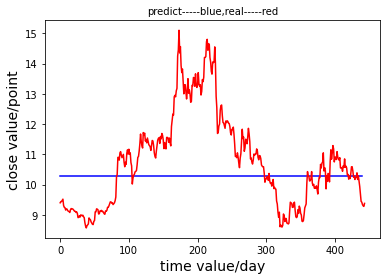

Exception in Tkinter callback
Traceback (most recent call last):
  File "/Users/rumeng/opt/anaconda3/lib/python3.9/tkinter/__init__.py", line 1892, in __call__
    return self.func(*args)
  File "/var/folders/97/t5p37xd91tbg2h4b_0h0x6t00000gn/T/ipykernel_5540/2176248138.py", line 38, in <lambda>
    button1 = tk.Button(win, text="提交", command=lambda: getLable(E1))
  File "/var/folders/97/t5p37xd91tbg2h4b_0h0x6t00000gn/T/ipykernel_5540/2176248138.py", line 46, in getLable
    gettraindata(string)
  File "/var/folders/97/t5p37xd91tbg2h4b_0h0x6t00000gn/T/ipykernel_5540/2176248138.py", line 91, in gettraindata
    main(data)
  File "/var/folders/97/t5p37xd91tbg2h4b_0h0x6t00000gn/T/ipykernel_5540/2176248138.py", line 97, in main
    var.set("预测的结果是：" + answer)
NameError: name 'var' is not defined


In [ ]:
# import tensorflow as tf
# import numpy as np
import tkinter as tk
from tkinter import filedialog
import time
from pandas import DataFrame
# import pandas as pd




def creat_windows():
    win = tk.Tk()  # 创建窗口
    sw = win.winfo_screenwidth()
    sh = win.winfo_screenheight()
    ww, wh = 800, 450
    x, y = (sw - ww) / 2, (sh - wh) / 2
    win.geometry("%dx%d+%d+%d" % (ww, wh, x, y - 40))  # 居中放置窗口

    win.title('LSTM股票预测')  # 窗口命名

    f_open =open('/Users/rumeng/Downloads/qingzang/trainSet2/data/上海.csv')
    canvas = tk.Label(win)
    canvas.pack()

    var = tk.StringVar()  # 创建变量文字
    var.set('选择数据集')
    tk.Label(win, textvariable=var, bg='#C1FFC1', font=('宋体', 21), width=20, height=2).pack()

    tk.Button(win, text='选择数据集', width=20, height=2, bg='#FF8C00', command=lambda: getdata(var, canvas),
              font=('圆体', 10)).pack()

    canvas = tk.Label(win)
    L1 = tk.Label(win, text="选择你需要的 列(请用空格隔开，从0开始）")
    L1.pack()
    E1 = tk.Entry(win, bd=5)
    E1.pack()
    button1 = tk.Button(win, text="提交", command=lambda: getLable(E1))
    button1.pack()
    canvas.pack()
    win.mainloop()

def getLable(E1):
    string = E1.get()
    print(string)
    gettraindata(string)

def getdata(var, canvas):
    print('getdata')
    global file_path
    file_path = filedialog.askopenfilename()
    var.set("注，最后一个为label")
    # 读取文件第一行标签
    with open(file_path, 'r', encoding='gb2312') as f:
#     with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()  # 读取所有行
        data2 = lines[0]
    print()

    canvas.configure(text=data2)
    canvas.text = data2

def gettraindata(string):
    print('gettraindata')
#     f_open = open(file_path)
#     df = pd.read_csv(f_open)  # 读入股票数据
#     df = pd.read_csv(file_path,on_bad_lines='skip',encoding='utf-8-sig',engine='python')
    myDict = {"Stkcd": [], "Trddt": [], "Opnprc": [], "Hiprc": [], 
          "Loprc": [], "Clsprc": [], "Dnshrtrd": [], "Dnvaltrd": [], 
          "Dsmvosd": [], "Dsmvtll": [], "Dretwd": [], "ChangeRatio": []}
    with open(file_path, 'r',encoding='utf-8-sig') as f:
        lines = f.readlines()
        for line in lines:
            stkInfo = json.loads(line)
            for i in myDict.keys():
                myDict[i].append(stkInfo[i])
    df = DataFrame(myDict)
    list = string.split()
    print(list)
    x = len(list)
    index=[]
    # data = df.iloc[:, [1,2,3]].values  # 取第3-10列 （2:10从2开始到9）
    for i in range(x):
        q = int(list[i])
        index.append(q)
    global data
    data = df.iloc[:, index]
    data = data[data!=-100].dropna()
    data = data.values
    print(data)
    main(data)

def main(data):
    print('pred begin')
    pred = LSTMtest(data)
#     pred.LSTMtest(data)
    var.set("预测的结果是：" + answer)

if __name__ == "__main__":
    creat_windows()

# 16ret(-1) 18ret 28ris 29smb 30hml
# 20snow 20 16 28 29 30 18

In [4]:
import pandas as pd
from pandas import DataFrame
myDict = {"Stkcd": [], "Trddt": [], "Opnprc": [], "Hiprc": [], 
          "Loprc": [], "Clsprc": [], "Dnshrtrd": [], "Dnvaltrd": [], 
          "Dsmvosd": [], "Dsmvtll": [], "Dretwd": [], "ChangeRatio": []}
with open('/Users/rumeng/Downloads/qingzang/trainSet/stock/000001.json', 'r',encoding='utf-8-sig') as f:
    lines = f.readlines()
    for line in lines:
        stkInfo = json.loads(line)
        for i in myDict.keys():
            myDict[i].append(stkInfo[i])
df = DataFrame(myDict)
print(df)

       Stkcd       Trddt  Opnprc  Hiprc  Loprc  Clsprc    Dnshrtrd  \
0     000001  2000-01-04   17.50  18.55  17.20   18.29   8216086.0   
1     000001  2000-01-05   18.35  18.85  18.00   18.06   9399315.0   
2     000001  2000-01-06   18.02  19.05  17.75   18.78  12022209.0   
3     000001  2000-01-07   19.00  19.77  18.90   19.54  22934633.0   
4     000001  2000-01-10   19.79  20.48  19.77   20.14  18521078.0   
...      ...         ...     ...    ...    ...     ...         ...   
4436  000001  2018-12-24    9.40   9.45   9.31    9.42  50911767.0   
4437  000001  2018-12-25    9.29   9.43   9.21    9.34  58661545.0   
4438  000001  2018-12-26    9.35   9.42   9.27    9.30  42114060.0   
4439  000001  2018-12-27    9.45   9.49   9.28    9.28  62459327.0   
4440  000001  2018-12-28    9.31   9.46   9.31    9.38  57660400.0   

          Dnvaltrd       Dsmvosd       Dsmvtll    Dretwd  ChangeRatio  
0     1.473254e+08  1.958681e+07  2.838328e+07  0.048138     0.048138  
1     1.734752e

In [ ]:
import pandas as pd
from os import listdir
from pandas import DataFrame
stockPath='/Users/rumeng/Downloads/qingzang/trainSet/stock/'
stklist = []
myDict = {"Stkcd": [], "Trddt": [], "Opnprc": [], "Hiprc": [], 
          "Loprc": [], "Clsprc": [], "Dnshrtrd": [], "Dnvaltrd": [], 
          "Dsmvosd": [], "Dsmvtll": [], "Dretwd": [], "ChangeRatio": []}
with open(stockPath+'all.json', 'r',encoding='utf-8-sig') as f:
    lines = f.readlines()
    for line in lines:
        stkInfo = json.loads(line)
        if stkInfo["Stkcd"] not in stklist:
            stklist.append(stkInfo["Stkcd"])
        for i in myDict.keys():
            myDict[i].append(str(stkInfo[i]))
df = DataFrame(myDict)
# print(df)
# df.to_csv(stockPath+'all1.csv'encoding=ng='utf-8-sig')
print('-------------')
# print(stklist)

In [ ]:
print(len(stklist))

In [1]:
import pandas as pd
df = pd.read_csv('/Users/rumeng/Downloads/qingzang/trainSet/stock/all1.csv')
print(df[df.isnull().T.any()]) #找出有空值的行
# 这里是将NaN替换为None
# ini_df是你要插入数据库的DataFrame,  df是将NAN替换完为None的DataFrame
df2 = df.astype(object).where(pd.notnull(df), None)

         Unnamed: 0   Stkcd       Trddt  Opnprc  Hiprc  Loprc  Clsprc  \
68456         68456      70  2000-05-11   22.90  35.00  22.90   28.70   
74320         74320      96  2000-07-24   11.98  12.28  11.01   11.59   
75378         75378      99  2000-07-31   21.01  21.78  19.42   19.50   
76657         76657     150  2000-08-07   15.47  18.11  15.20   17.87   
77699         77699     151  2000-09-06   20.00  21.00  17.80   17.93   
...             ...     ...         ...     ...    ...    ...     ...   
5919644     5919644  601607  2010-01-28   14.75  15.05  14.51   15.01   
5919645     5919645  601607  2010-01-29   14.99  15.50  14.85   15.40   
5919646     5919646  601607  2010-02-01   15.42  16.24  15.40   16.20   
5919647     5919647  601607  2010-02-02   16.10  16.10  14.90   14.98   
5919648     5919648  601607  2010-02-03   14.71  15.40  13.50   14.73   

           Dnshrtrd      Dnvaltrd     Dsmvosd     Dsmvtll    Dretwd  \
68456    31469614.0  9.371621e+08  1808100.00  71750

In [4]:
stockPath='/Users/rumeng/Downloads/qingzang/trainSet/stock/'
df2.to_csv(stockPath+'all2.csv',encoding='utf-8-sig')

In [6]:
import json
import pandas as pd
from os import listdir
from pandas import DataFrame
myDict={}
filePath = '/Users/rumeng/Downloads/qingzang/trainSet2/candidate/'
fileList = listdir(filePath)
for fileName in fileList:
    if '.json' not in fileName:
        continue
    city = fileName.replace('.json','')
    print(city)
    myDict[city]=[]
    with open(filePath+fileName, 'r',encoding='utf-8-sig') as f:
        lines = f.readlines()
        for line in lines:
            dateInfo = json.loads(line)
            for key in dateInfo['stkcd'].keys():
                if key not in myDict[city]:
                    myDict[city].append(key)
result={'city':[],'stkcd':[]}
for city in myDict.keys():
    result['city'].append(city)
    result['stkcd'].append('#'.join(myDict[city]))
df = DataFrame(result)
df.to_csv(filePath+'all.csv',encoding='utf-8-sig')

镇江
杭州
徐州
潍坊
西宁
嘉兴
保定
许昌
柳州
株洲
广州
东莞
铜陵
南阳
桂林
包头
龙岩
重庆
哈尔滨
淄博
洛阳
荆门
兰州
温州
湖州
常州
绵阳
石家庄
银川
南宁
衢州
滨州
鞍山
德州
无锡
南通
襄阳
武汉
长沙
大连
梅州
沈阳
乐山
西安
南昌
惠州
连云港
福州
北京
德阳
济宁
郑州
珠海
乌鲁木齐
岳阳
呼和浩特
宁波
拉萨
赣州
新乡
天津
江门
南京
长春
吉林
济南
汕头
太原
海口
台州
宝鸡
青岛
威海
昆明
贵阳
上海
益阳
深圳
揭阳
滁州
绍兴
唐山
合肥
厦门
苏州
焦作
金华
泉州
泰州
衡阳
漳州
成都
芜湖
扬州
盐城
佛山
烟台
潮州
宿迁
肇庆
宜昌
